# Near-Surface Air Temperature bias LS3MIP IPSL
conda env: `phd_v3` (in `envs/phd`)

Try to compare the **temperature** for the **CMIP6 historical** experiments: **coupled** + **land-hist**
- Zone: **NH** (try to see other mountainous areas)
- Period: **1979-2014**
- Model: **IPSL-CMA6-LR**
- Observation: **CRU TS4.04** Climatic Research Unit (CRU) Time-Series (TS) version 4.04 of high-resolution gridded data of month-by-month variation in climate (Jan. 1901- Dec. 2019): http://data.ceda.ac.uk/badc/cru/data/cru_ts/cru_ts_4.04/data/tmp (station)

Created: 17/09/2020 - Last modified: 17/09/2020

## Import modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


## Set variables

In [5]:
period = slice('1979','2014')
seasons = ['Annual', 'DJF', 'JJA']

var = 'tas'
table = u.get_table(var)
label, units, cmap, levels = u.get_var_infos(var)
label

'Near-Surface Air Temperature'

## Load models

In [6]:
# list_models = u.get_model_names()
list_models = ['IPSL-CM6A-LR']

for i, model in enumerate(list_models):
    print(model + ' ('+str(i+1)+'/'+str(len(list_models))+')')
    institute, grid, realization, calendar = u.get_model_infos(model, var)
    print(institute, grid, realization, calendar)

IPSL-CM6A-LR (1/1)
IPSL gr r1i1p1f1 gregorian


In [7]:
# Load historical
da_historical = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var].chunk({'time': -1, 'lon': -1, 'lat': -1}) - 273.15

# Load land-hist
da_land_hist = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/'+institute+'/'+model+'/land-hist/'+realization+'/'+table+'/'+var+'/'+grid+'/latest/*.nc', 
    combine='by_coords'
).sel(time=period)[var].chunk({'time': -1, 'lon': -1, 'lat': -1}) -273.15

# Check if the time steps are ok
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, da_historical.time.size)
np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, da_land_hist.time.size)

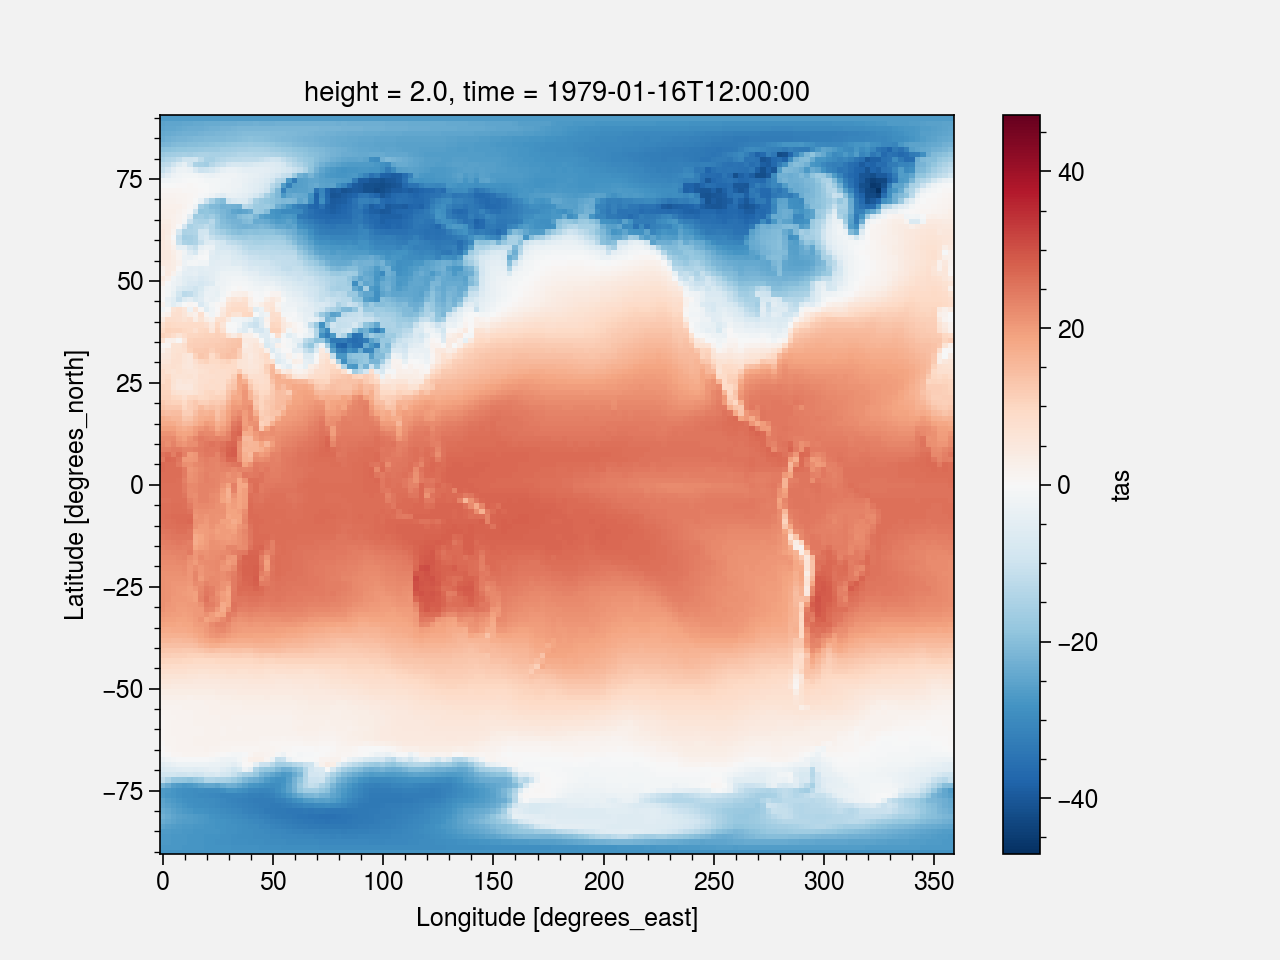

In [8]:
da_historical.isel(time=0).plot()

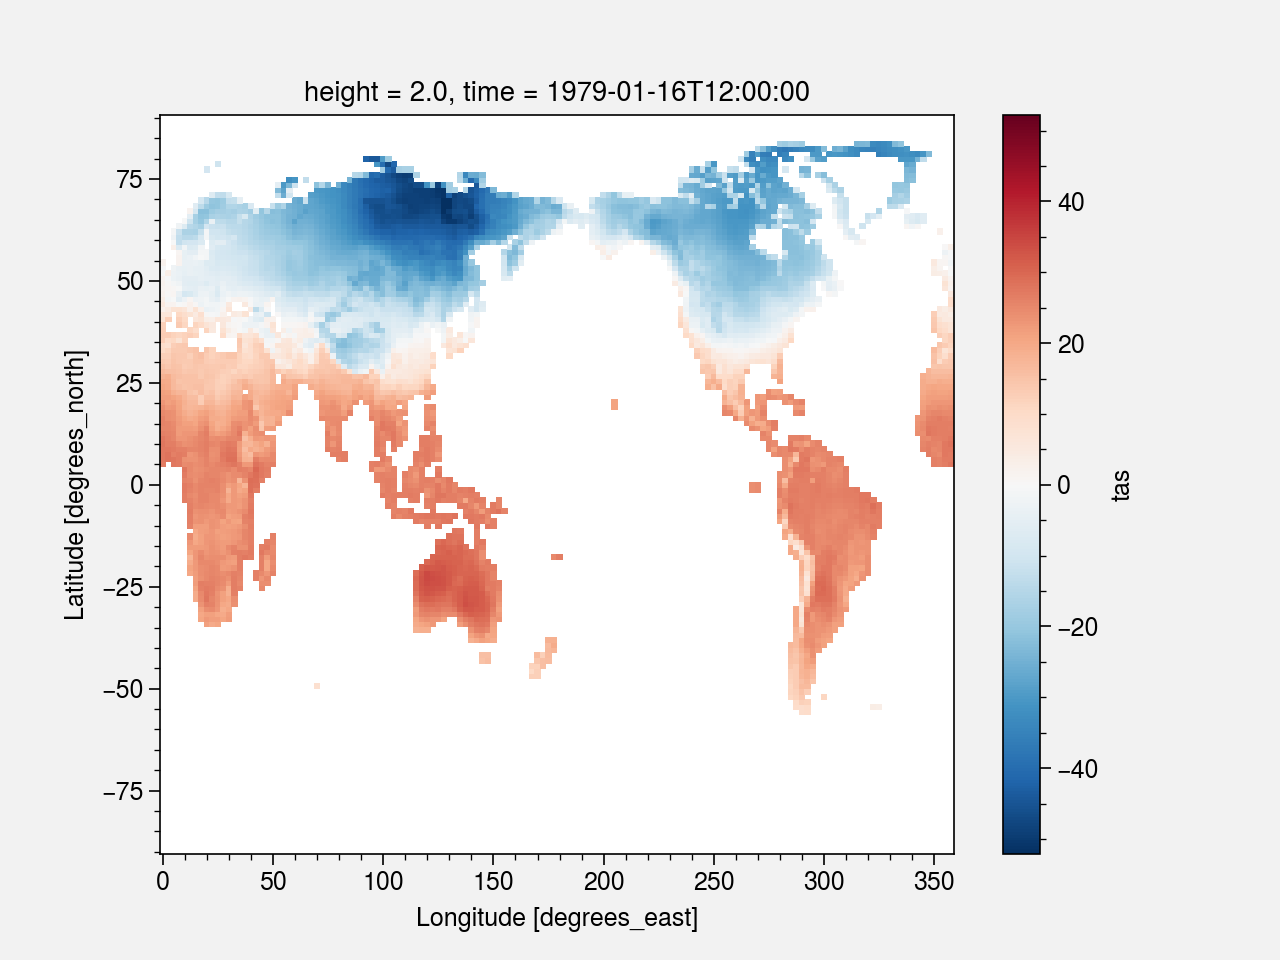

In [9]:
da_land_hist.isel(time=0).plot()

## Load observation
**CRU TS4.04** Climatic Research Unit (CRU) Time-Series (TS) version 4.04 of high-resolution gridded data of month-by-month variation in climate (Jan. 1901- Dec. 2019): http://data.ceda.ac.uk/badc/cru/data/cru_ts/cru_ts_4.04/data/tmp (station)

*The gridded Climatic Research Unit (CRU) Time-series (TS) data version 4.04 data are **month-by-month** variations in climate over the **period 1901-2019**, provided on **high-resolution (0.5x0.5 degree)** grids, produced by CRU at the University of East Anglia and funded by the UK National Centre for Atmospheric Science (NCAS), a NERC collaborative centre.*

*The CRU TS4.04 data were produced using **angular-distance weighting (ADW) interpolation**. All versions prior to 4.00 used triangulation routines in IDL. Please see the release notes for full details of this version update.*

*The CRU TS4.04 data are monthly gridded fields based on monthly observational data calculated from daily or sub-daily data by National Meteorological Services and other external agents. The ASCII and NetCDF data files both contain monthly mean values for the various parameters. The NetCDF versions contain an additional integer variable, ’stn’, which provides, for each datum in the main variable, a count (between 0 and 8) of the number of stations used in that interpolation. The missing value code for 'stn' is -999.*

*All CRU TS output files are actual values - NOT anomalies.*

In [20]:
obs_ds = xr.open_dataset('/data/mlalande/CRU/tmp/cru_ts4.04.1901.2019.tmp.dat.nc').sel(time=period)

In [ ]:
# obs_ds

In [21]:
obs = obs_ds.tmp
obs.attrs['units'] = '°C'
obs.attrs['long_name'] = 'Climatic Research Unit (CRU) Time-Series (TS) version 4.04'
obs.attrs['short_name'] = 'CRU TS4.04'

In [25]:
# obs

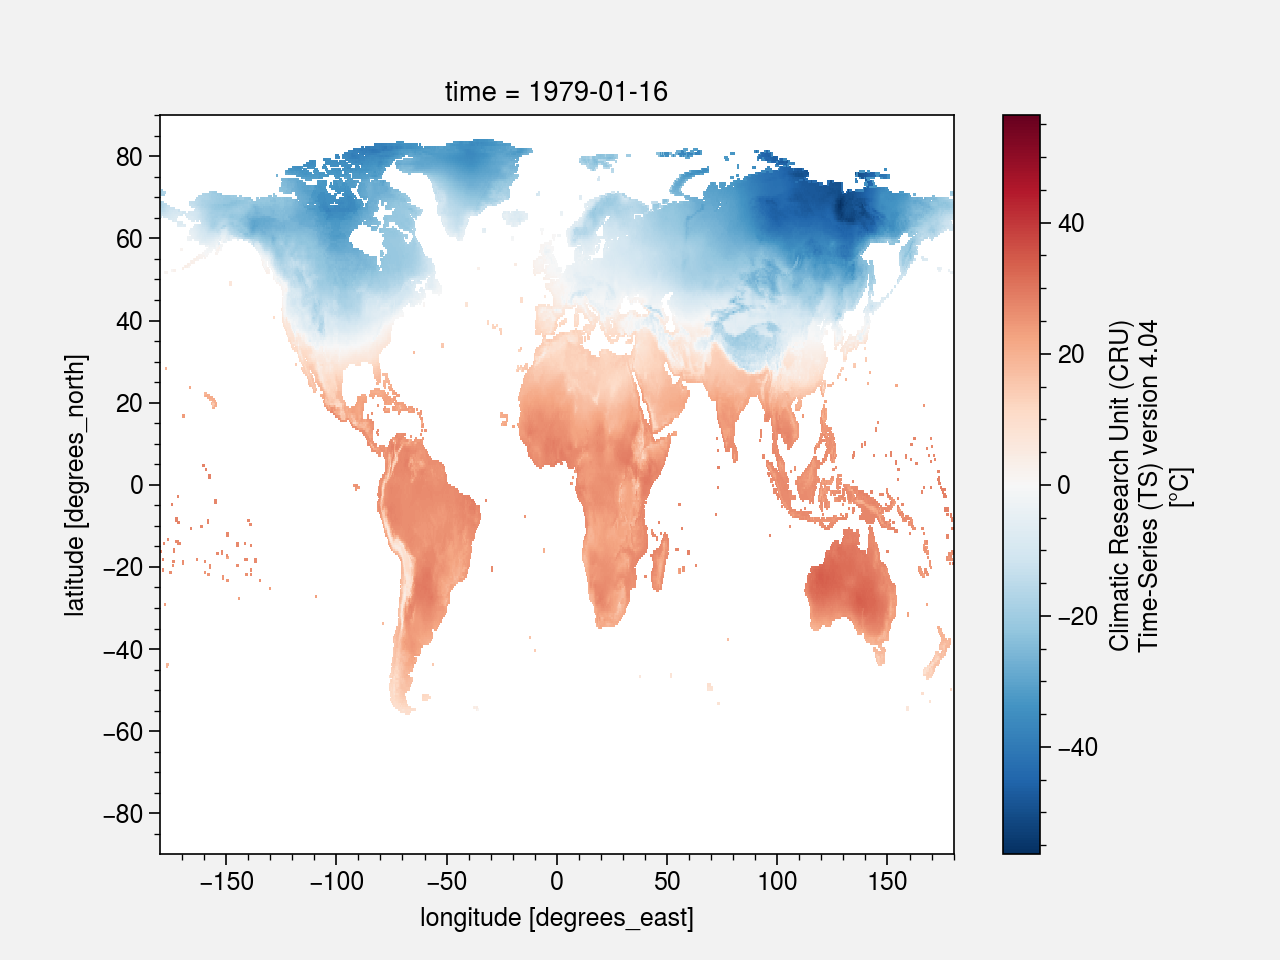

In [23]:
obs.isel(time=0).plot()

## Regrid observation to the model grid
Using xESMF (https://xesmf.readthedocs.io/en/latest/)

In [26]:
# # To put NaNs instead of 0 where there is no data (https://github.com/JiaweiZhuang/xESMF/issues/15)
# import scipy
# def add_matrix_NaNs(regridder):
#         X = regridder.weights
#         M = scipy.sparse.csr_matrix(X)
#         num_nonzeros = np.diff(M.indptr)
#         M[num_nonzeros == 0, 0] = np.NaN
#         regridder.weights = scipy.sparse.coo_matrix(M)
#         return regridder


regridder = xe.Regridder(obs, da_historical, 'bilinear', periodic=True, reuse_weights=True)
# regridder = add_matrix_NaNs(regridder)
obs_regrid = regridder(obs)

Reuse existing file: bilinear_360x720_143x144_peri.nc


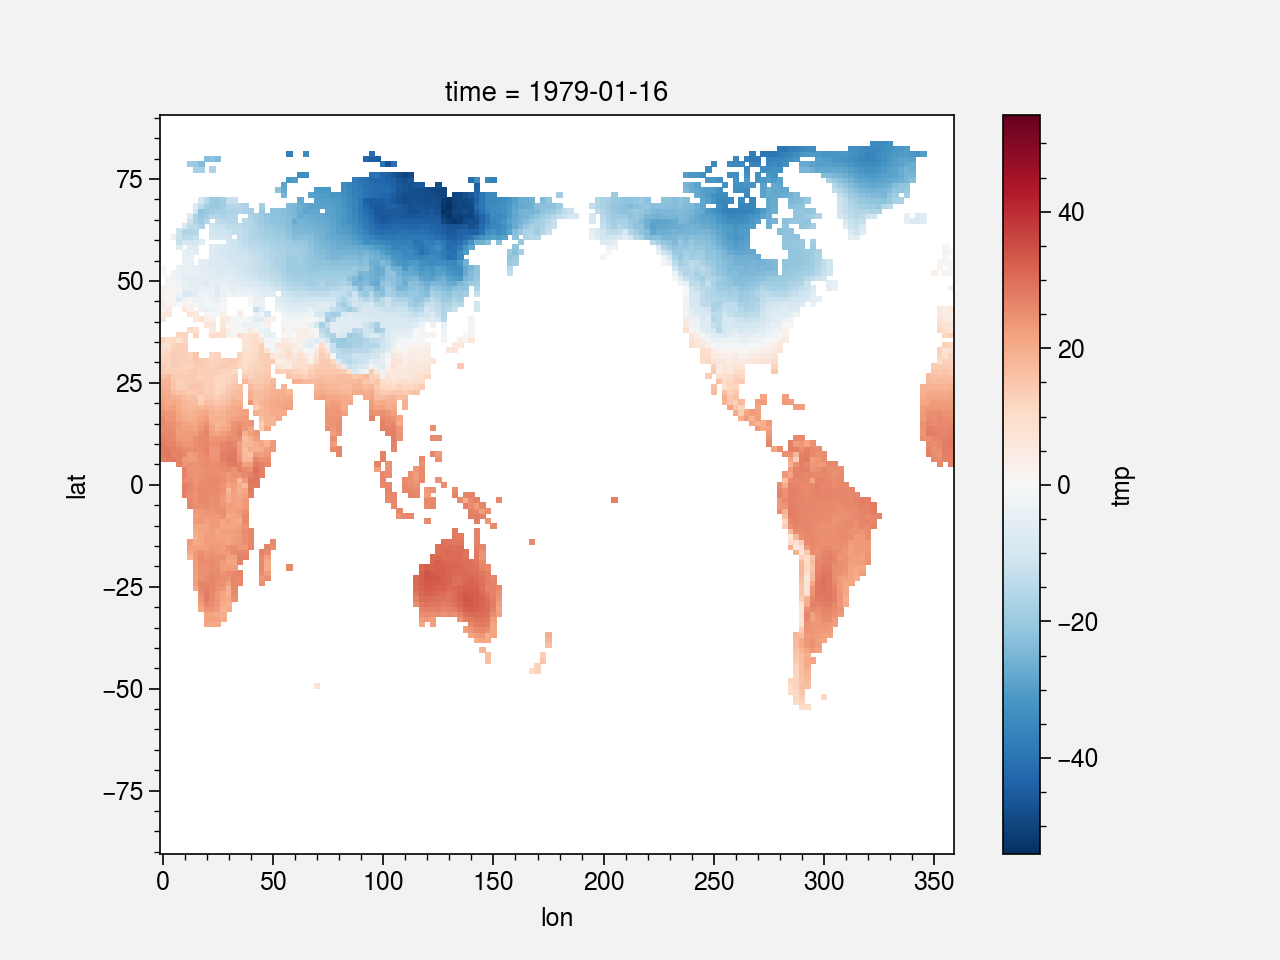

In [17]:
obs_regrid.isel(time=0).plot()

## Compare plots

### First time step

In [33]:
xr.ufuncs.fabs(obs_regrid.isel(time=itime).sel(lat=slice(0,90))).max().values

array(54.12916834)

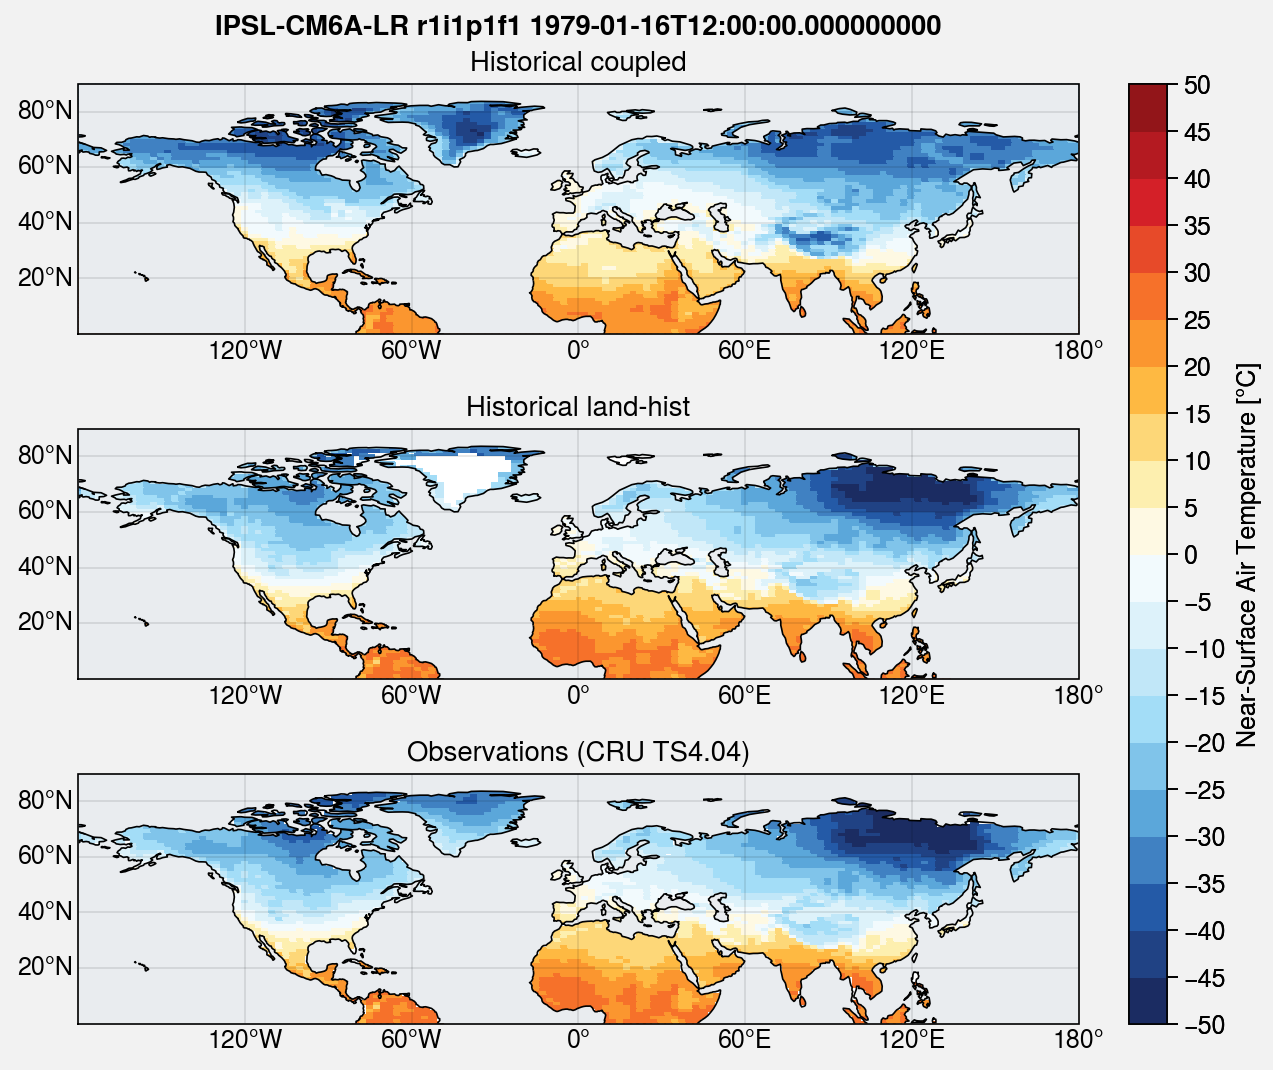

In [36]:
fig, axs = plot.subplots(nrows=3, ncols=1, proj='cyl', axwidth=5)

cmap='ColdHot'
levels=plot.arange(-50,50,5)
itime=0

axs.format(
    labels=True,
    latlim=(0,90),
    ocean=True, oceancolor='gray2',
    coast=True,
    suptitle=model+' '+realization+' '+str(da_historical.isel(time=itime).time.values)
)

axs[0].pcolormesh(da_historical.isel(time=itime), cmap=cmap, levels=levels)
axs[0].format(title='Historical coupled')

axs[1].pcolormesh(da_land_hist.isel(time=itime), cmap=cmap, levels=levels)
axs[1].format(title='Historical land-hist')

m = axs[2].pcolormesh(obs_regrid.isel(time=itime), cmap=cmap, levels=levels)
axs[2].format(title='Observations ('+obs.short_name+')')

fig.colorbar(m, label=label+' ['+units+']')

### Climatology

In [37]:
clim_historical = [None]*len(seasons)
clim_land_hist = [None]*len(seasons)
clim_obs_regrid = [None]*len(seasons)

for i, season in enumerate(seasons):
    clim_historical[i] = u.clim(da_historical, season=season, calendar=calendar)
    clim_land_hist[i] = u.clim(da_land_hist, season=season, calendar=calendar)
    clim_obs_regrid[i] = u.clim(obs_regrid, season=season, calendar=calendar)

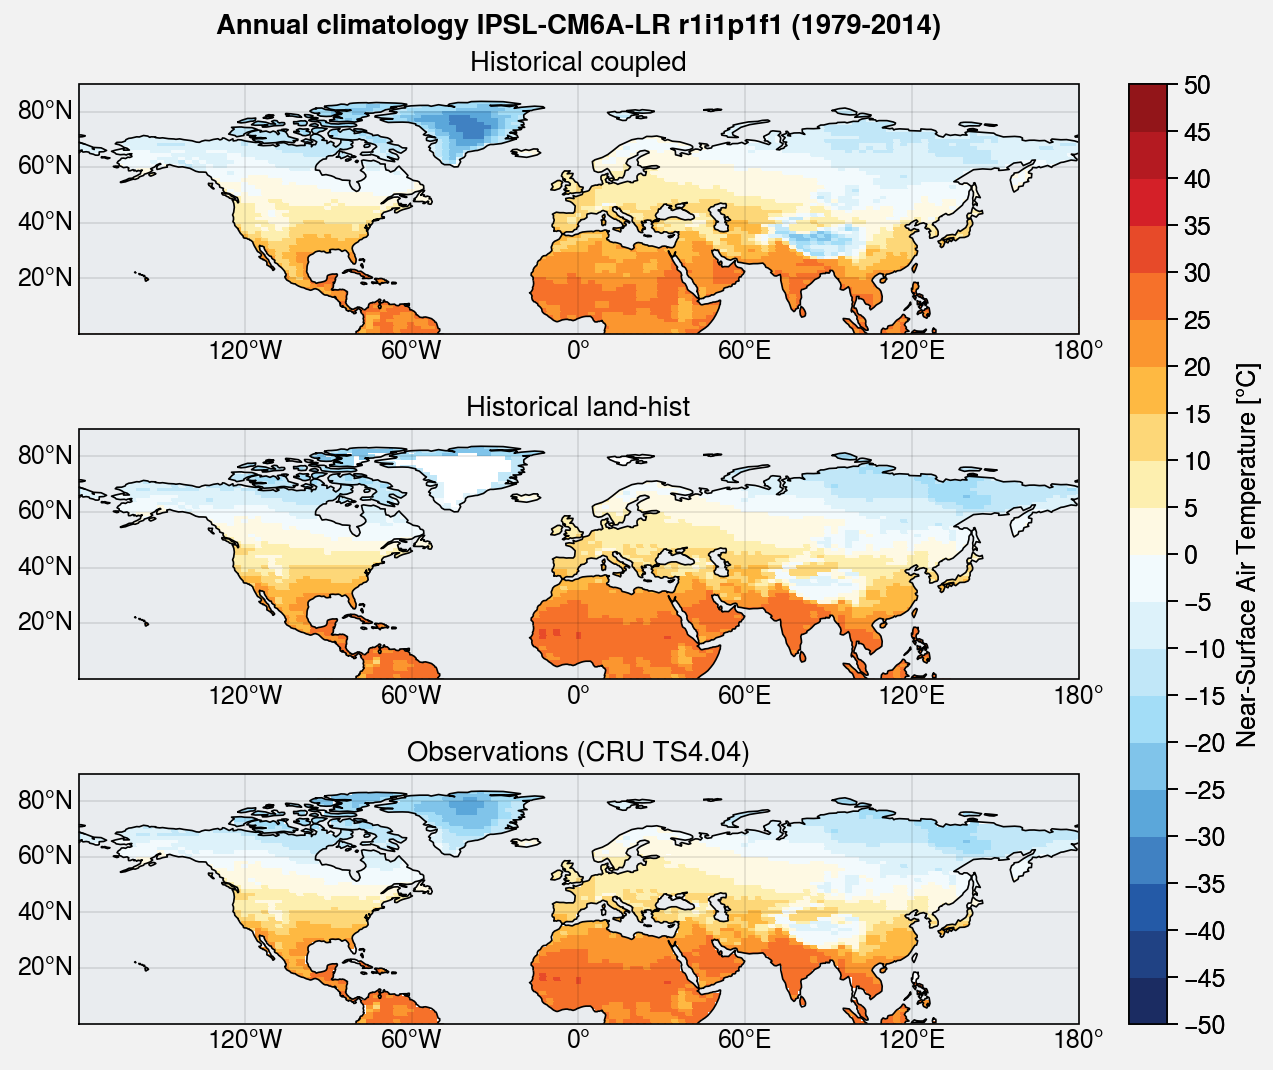

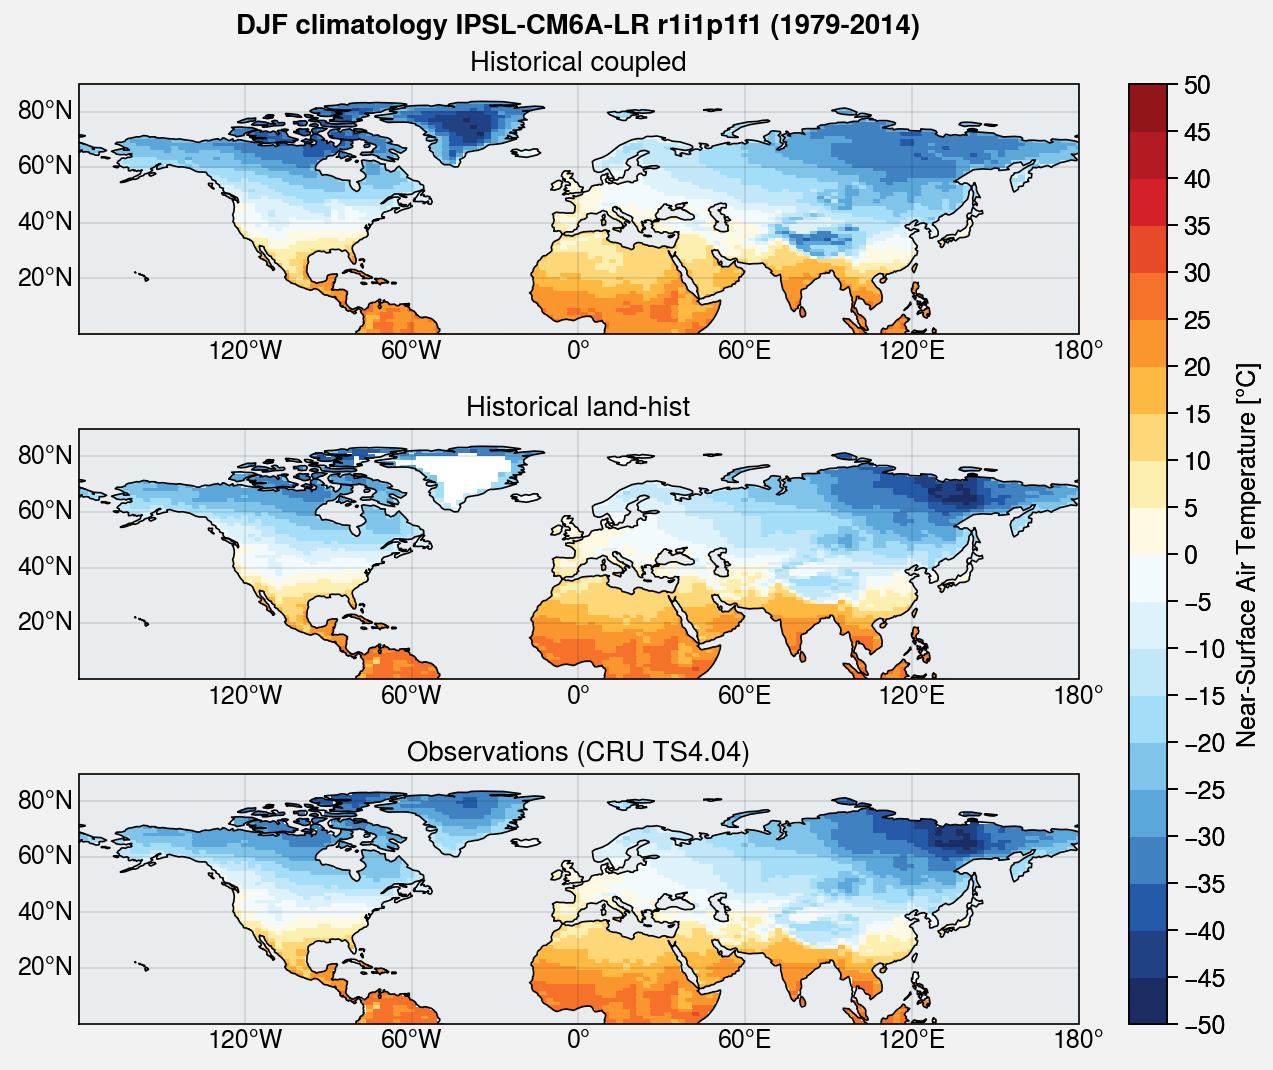

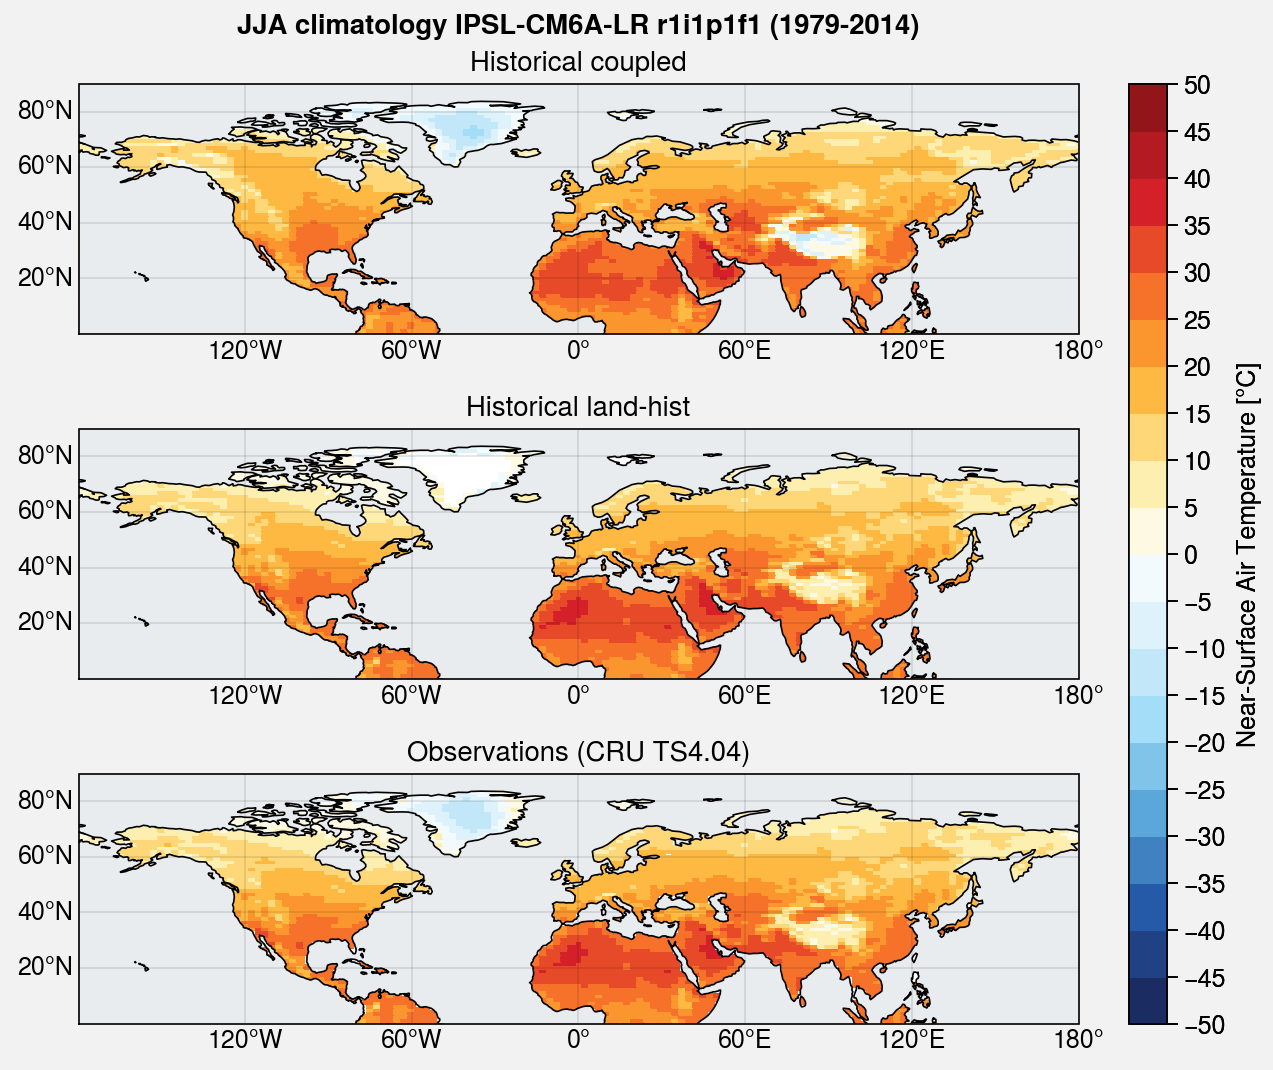

In [38]:
for i, season in enumerate(seasons):    
    fig, axs = plot.subplots(nrows=3, ncols=1, proj='cyl', axwidth=5)

    cmap='ColdHot'
    levels=plot.arange(-50,50,5)

    axs.format(
        labels=True,
        latlim=(0,90),
        ocean=True, oceancolor='gray2',
        coast=True,
        suptitle=season+' climatology '+model+' '+realization+' ('+period.start+'-'+period.stop+')'
    )

    axs[0].pcolormesh(clim_historical[i], cmap=cmap, levels=levels)
    axs[0].format(title='Historical coupled')

    axs[1].pcolormesh(clim_land_hist[i], cmap=cmap, levels=levels)
    axs[1].format(title='Historical land-hist')

    m = axs[2].pcolormesh(clim_obs_regrid[i], cmap=cmap, levels=levels)
    axs[2].format(title='Observations ('+obs.short_name+')')

    fig.colorbar(m, label=label+' ['+units+']')
    
    filename = season+'_'+var+'_clim_CDR_'+model+'_'+realization+'_LS3MIP_'+period.start+'-'+period.stop
    fig.save('img/IPSL/'+filename+'.jpg'), fig.save('img/IPSL/'+filename+'.png'), fig.save('img/IPSL/'+filename+'.pdf')

## Bias

In [40]:
bias_historical = [None]*len(seasons)
bias_land_hist = [None]*len(seasons)

for i, season in enumerate(seasons):
    bias_historical[i] = clim_historical[i] - clim_obs_regrid[i]
    bias_land_hist[i] = clim_land_hist[i] - clim_obs_regrid[i]

In [41]:
for i, season in enumerate(seasons):
    print(xr.ufuncs.fabs(bias_historical[i]).sel(lat=slice(0,90)).max().values, xr.ufuncs.fabs(bias_land_hist[i]).max().values)

18.309837506843632 1.2237978244929941
19.058391761114297 1.0258772810808097
18.41066263277359 1.6002152233002893


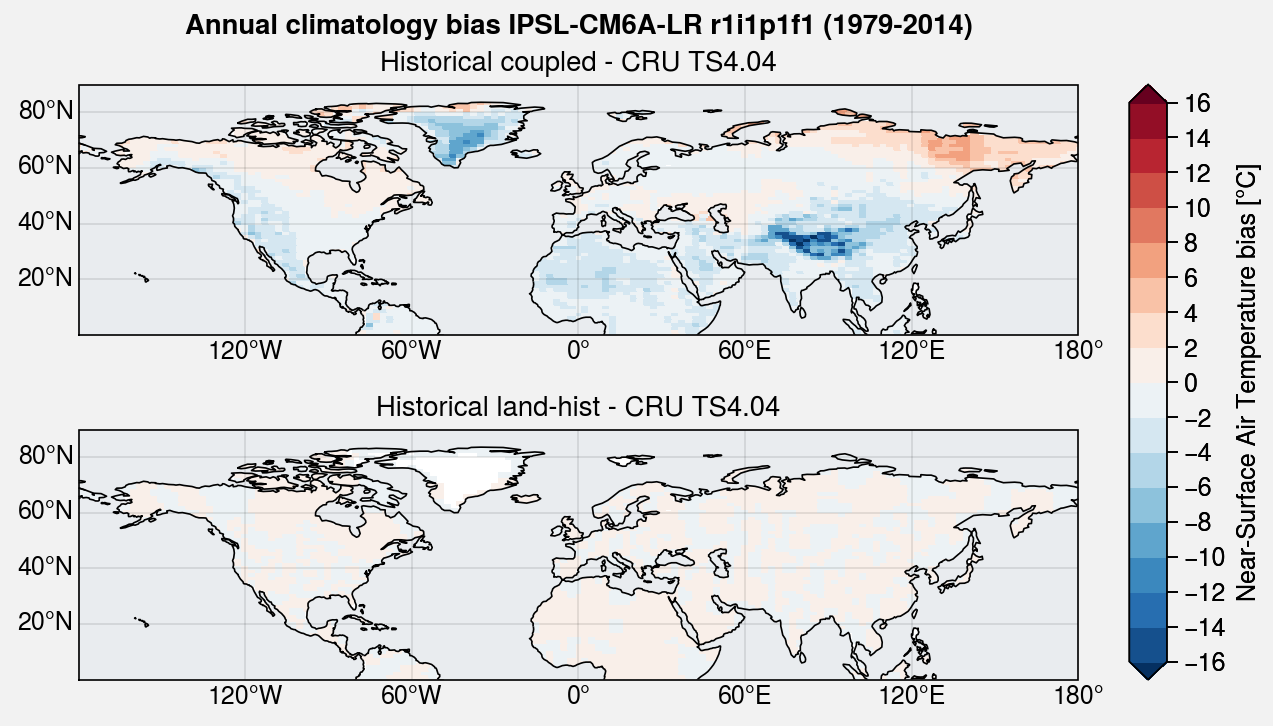

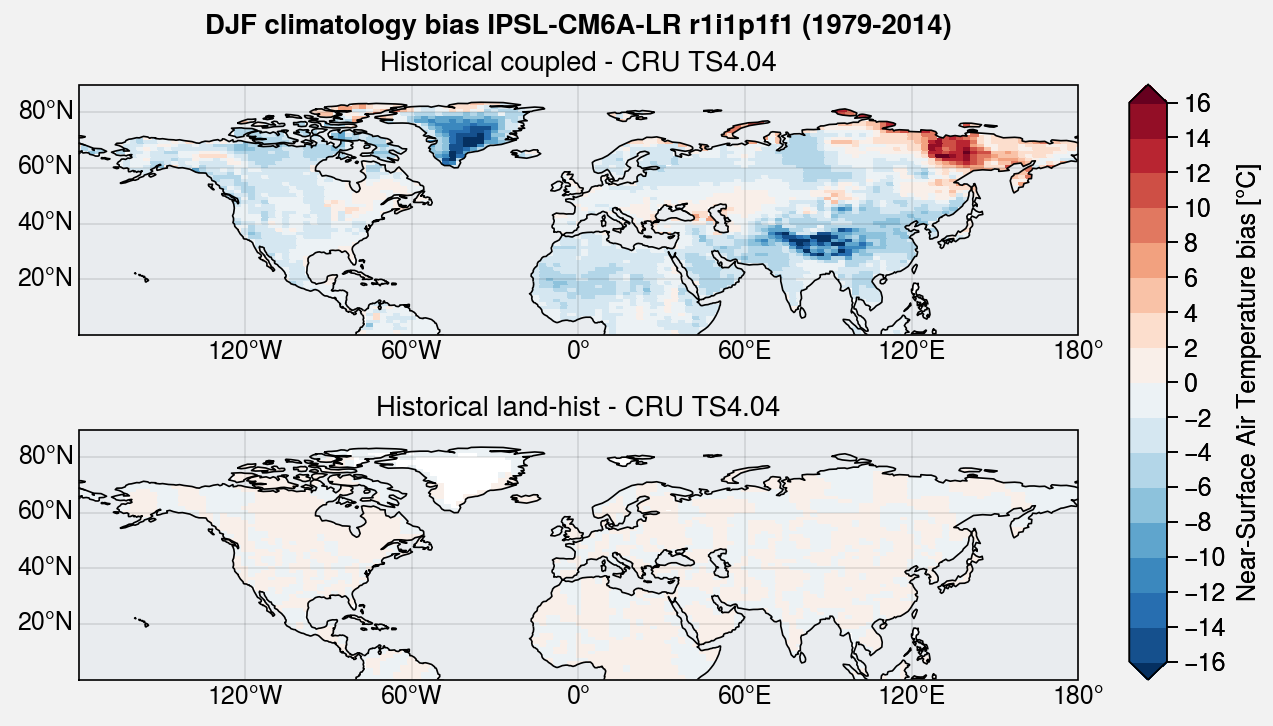

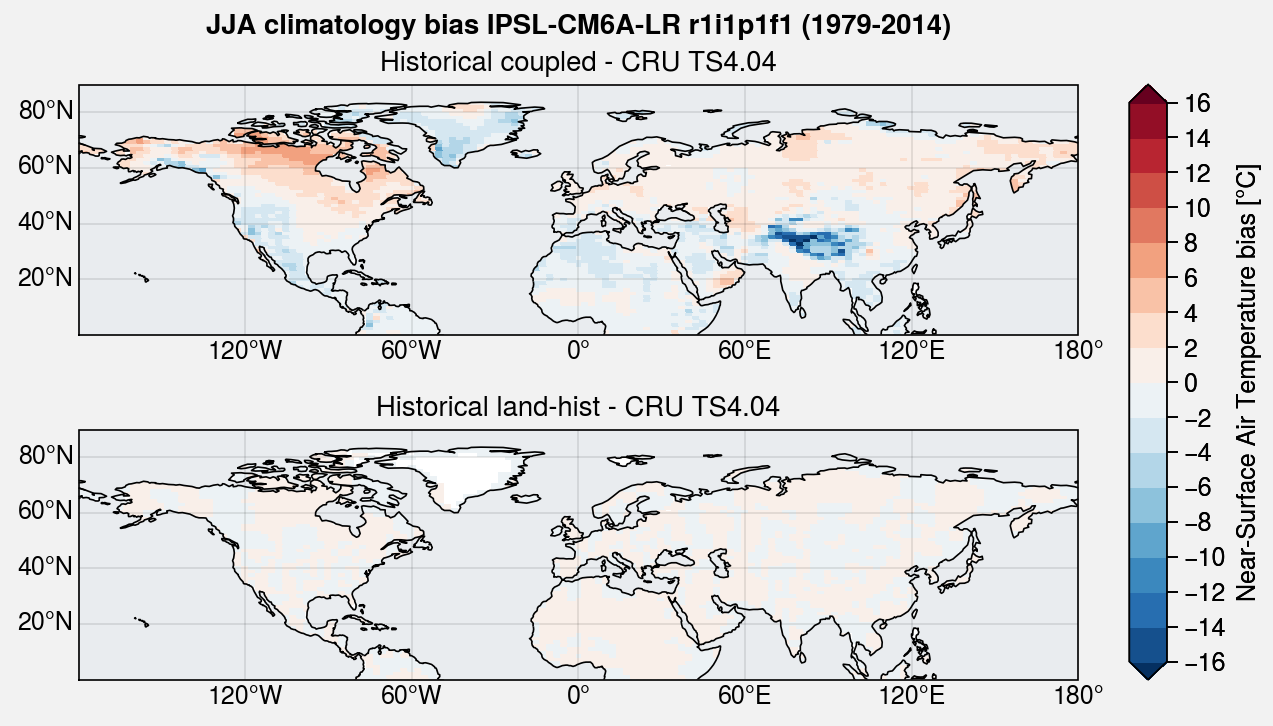

In [48]:
for i, season in enumerate(seasons):   
# for i, season in enumerate(['Annual']):   
    fig, axs = plot.subplots(nrows=2, ncols=1, proj='cyl', axwidth=5)

    cmap='RdBu_r'
    levels=plot.arange(-16,16,2)
    extend='both'

    axs.format(
        labels=True,
        latlim=(0,90),
        ocean=True, oceancolor='gray2',
        coast=True, borders=False,
        suptitle=season+' climatology bias '+model+' '+realization+' ('+period.start+'-'+period.stop+')'
    )

    axs[0].pcolormesh(bias_historical[i], cmap=cmap, levels=levels, extend=extend)
    axs[0].format(title='Historical coupled - '+obs.short_name)

    m = axs[1].pcolormesh(bias_land_hist[i], cmap=cmap, levels=levels, extend=extend)
    axs[1].format(title='Historical land-hist - '+obs.short_name)

    fig.colorbar(m, label=label+' bias ['+units+']')

    filename = season+'_'+var+'_bias_CDR_'+model+'_'+realization+'_LS3MIP_'+period.start+'-'+period.stop
    fig.save('img/IPSL/'+filename+'.jpg'), fig.save('img/IPSL/'+filename+'.png'), fig.save('img/IPSL/'+filename+'.pdf')